In [1]:
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

In [2]:
import os
os.getcwd()
path1 = 'E:\\SIF data\\FPAR_2016'
path2 = 'E:\\SIF data\\GOME_2016\\GOME_2016\\'
os.chdir('E:\\SIF data\\FPAR_2016')
# os.chdir('E:\\SIF data\\GOME_2016\\GOME_2016\\')

In [ ]:
import my_functions
my_functions.coords_to_ind(-90,30)

In [ ]:
ILLINOIS = (36.7281, -91.8524, 42.493703, -87.020001)
ILLINOIS = (30, -120, 49, -80)
arr_ = []


def find_max_qc(ILLINOIS):
    
    qc_data = None
    fpar_data = None
    prefix ='FPAR_A2016'
    suffix = '.hdf'
    max_ = -np.inf
    acc = []
    for i in range(1,361,8):
        a = str(int(i))
        if i < 10:
            a = '00'+ a
        elif i < 100:
            a = '0' + a

        query = prefix + a + suffix
        try:
            data = SD(query, SDC.READ)
            print('read')
            cur_fpar = data.select('Fpar_500m')[:]
            cur_qc = data.select('FparExtra_QC')[:]
            left, down = my_functions.coords_to_ind(ILLINOIS[1], ILLINOIS[0])
            right, up = my_functions.coords_to_ind(ILLINOIS[3], ILLINOIS[2])
            print(right, left)
            print(down, up)
            qcs = cur_qc[up:down, left:right].flatten()
            ratio = my_functions.good_qc(qcs)
            acc.append([ratio, query])
#             print(ratio)
#             if ratio > max_:
#                 fpar_data = cur_fpar
#                 qc_data = cur_qc
#                 max_ = ratio

        except:
            continue
        
    return fpar_data, qc_data, acc
        
        

def run_fpar_workflow(ILLINOIS, fpar_data, qc_data):
    arr_ = []
    
    for i in np.arange(ILLINOIS[0], ILLINOIS[2], 0.1):
        for j in np.arange(ILLINOIS[1], ILLINOIS[3], 0.1):
            cur_lat, cur_lon = i,j
            
            lon_ind, lat_ind = my_functions.coords_to_ind(cur_lon, cur_lat)
            fp, qc = fpar_data[lat_ind, lon_ind], qc_data[lat_ind, lon_ind]
            if my_functions.get_cloud(qc)[0] == '0' and my_functions.get_cloud(qc)[1] == '0':
                arr_.append([cur_lat, cur_lon, fp])

    return arr_

def find_fpar_date(fpar):
    prefix ='FPAR_A2016'
    suffix = '.hdf'
    suspects = []
    for i in range(1,361,8):
        a = str(int(i))
        if i < 10:
            a = '00'+ a
        elif i < 100:
            a = '0' + a

        query = prefix + a + suffix
        try:
            data = SD(query, SDC.READ)
            print('read')
            cur_fpar = data.select('Fpar_500m')[:]
            cur_qc = data.select('FparExtra_QC')[:]
            if np.mean(cur_fpar) == np.mean(fpar):
                print(query)
                suspects.append(query)
        except:
            continue
        
    return suspects
    



In [ ]:
fp_dat, qc_dat,acc = find_max_qc(ILLINOIS)

In [ ]:
cleaned_acc = sorted(acc, key = lambda x: x[0], reverse = True)

In [ ]:
cleaned_acc

In [ ]:
filtered_fpar = run_fpar_workflow(ILLINOIS, a,b)
print(filtered_fpar)

In [ ]:
dat = SD('FPAR_A2016225.hdf', SDC.READ)

fpp2 = dat.select('Fpar_500m')[:]
qc2 = dat.select('FparExtra_QC')[:]
print(fpp2.shape)
arr2 = run_fpar_workflow(ILLINOIS, fpp2, qc2)



In [ ]:
filtered_data = np.array(arr2)

In [ ]:
suspects = find_fpar_date(a)
print(suspects)

In [ ]:
filtered_data = np.array(filtered_fpar)

In [ ]:
filtered_data[:,2]

In [ ]:
from dbfread import DBF

In [ ]:
import sifutil
ILLINOIS = (36.7281, -91.8524, 42.493703, -87.020001)

<p><b>Functions for processing fpar data, like get cloud, convert the qc index</b></p>

In [ ]:
import numpy.linalg as la

def convert_binary(num):
    str_ = "{0:b}".format(num)
    if len(str_) < 8:
        str_ = '0'*(8-len(str_)) + str_
        
    return str_
        
def get_cloud(num):
    str_ = convert_binary(num)
    return str_[1], str_[2]


def interpolation(x,y):
    x = np.array(x)
    matrix = np.array([x**i for i in range(len(x))]).transpose()
    print(matrix)
    coeffs = la.solve(matrix,y)
    return coeffs

def get_smooth_line(x,y):
    coeffs = interpolation(x,y)
    x_values = np.linspace(min(x), max(x), 100)
    y_values = []
    for i in x_values:
        value = 0
        for j in range(len(coeffs)):
            value += coeffs[j]*i**j
            
        y_values.append(value)
    return [list(x_values), y_values]

In [ ]:
time_series = []
qc = []
x_values = []

<b>function for getting the whole fpar series for a year of a certain location (lat,lon)</b>

In [ ]:

def get_fpar_series(lat, lon):

    time_series = []
    qc = []
    x_values = []
    prefix ='FPAR_A2016'
    suffix = '.hdf'

    print(prefix+suffix)

    for i in range(1,9,8):
        a = str(int(i))
        if i < 10:
            a = '00'+ a
        elif i < 100:
            a = '0' + a

        query = prefix + a + suffix
        try:
            data = SD(query, SDC.READ)
            FPAR_data = data.select('Fpar_500m')[:]
            QC_data = data.select('FparExtra_QC')[:]

    #         print(QC_data.shape)
            Q = QC_data[lat,lon]
            time_series.append(FPAR_data[lat,lon])
            x_values.append(i)
            qc.append(Q)
            print(time_series)
            print(x_values)
            print(qc)
        except:
            continue

    return time_series, x_values, qc
    
    

# data = SD('FPAR_A2016361.hdf', SDC.READ)

<b>function for filtering the fpars with cloud, given qc arrays, x values and fpar series</b>

In [ ]:

def clean_data(time_series, x_values, qc):
    good_fpars = []
    good_dates = []
    for i in range(len(time_series)):
        if get_cloud(qc[i])[0] == '0' and get_cloud(qc[i])[1] == '0':
            good_fpars.append(time_series[i])
            good_dates.append(x_values[i])
            
    return good_dates, good_fpars

def good_qc(qc):
    cnt = 0
    for i in range(len(qc)):
        if get_cloud(qc[i])[0] == '0' and get_cloud(qc[i])[1] == '0':
            cnt += 1
            
    return cnt/len(qc)
#     return cnt/len(qc)
            


In [ ]:
%matplotlib inline
plt.plot(times)

In [ ]:
data = SD('FPAR_A2016225.hdf', SDC.READ).select('Fpar_500m')[:]

In [ ]:
import cv2
cv2.imwrite('225_august_fpar.jpg', data, 1)

In [ ]:
# from pyhdf.SD import SD, SDC
# import sifutil

In [ ]:
coords_to_ind(135, 40)

In [ ]:
import math
lat_eq = 360 / 40075
lon_eq = math.cos(self.lat_0) * 360 / 40057.
lon_a = self.lon_0 - ((self.side_len/2) * lon_eq)
lat_a = self.lat_0 - ((self.side_len/2) * lat_eq)
unit = self.side_len / 2

In [ ]:
from io import StringIO
import re
# import requests
# from bs4 import BeautifulSoup
# import pandas as pd
# import warnings
# BASE_CDL_URL = 'https://nassgeodata.gmu.edu/axis2/services/CDLService/GetCDLStat'
# CHAMPAIGN = 17019


# def from_csv(filepath):
#     df = pd.read_csv(filepath)
#     return df


# def get_by_fips(year, fips):
#     '''Grab CDL data for a county by FIPS code'''
#     url = BASE_CDL_URL + '?year=' + str(year) + '&fips=' + str(fips) + "&format=csv"
#     res = requests.get(url, verify = False)
#     returnurl = BeautifulSoup(res.text, 'lxml').find('returnurl').text
#     #print(returnurl)
#     rawdata = requests.get(returnurl, verify = False).text
#     raw_iter = StringIO(rawdata)
#     df = pd.read_csv(raw_iter, sep=" *, * ", engine='python')\
#            .apply(pd.to_numeric, errors='ignore')\
#            .set_index("Category")
#     return df




# def get_by_box(year, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat):
#     '''Grab CDL data by bounding box'''
#     x1, y1 = sifutil.convertProjection(llcrnrlon, llcrnrlat, sifutil.WGS84, sifutil.CONUS_ALBERS)
#     x2, y2 = sifutil.convertProjection(urcrnrlon, urcrnrlat, sifutil.WGS84, sifutil.CONUS_ALBERS)
#     url = BASE_CDL_URL + '?year=' + str(year) + '&bbox=' + str(min(x1,x2)) + "," +\
#           str(min(y1, y2)) + "," + str(max(x1, x2)) + "," + str(max(y1, y2)) + "&format=csv"
#     print(url)

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         res = requests.get(url, verify = False)
#         returnurl = BeautifulSoup(res.text, 'lxml').find('returnurl').text
#     #print(returnurl)
#     with warnings.catch_warnings():
#         rawdata = requests.get(returnurl, verify = False).text
#     raw_iter = StringIO(rawdata)
#     df = pd.read_csv(raw_iter, sep=" *, * ")\
#            .apply(pd.to_numeric, errors='ignore')\
#            .set_index("Category")
#     return df

In [ ]:
def getNC_GOME(filepath):
    data =  nc.Dataset(filepath, mode='r')
    lons = data['longitude'][:]
    lats = data['latitude'][:]
    sif = data['SIF_740'][:]
    data.close()
    return (lons, lats, sif)

In [ ]:
from mpl_toolkits.basemap import Basemap



In [ ]:
ILLINOIS = (36.7281, -91.8524, 42.493703, -87.020001)
bounding_box = (40.16, -89, 41, -87.5)
I_STATES_COORDS = (37, -96.65, 43.5, -84.81)
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def plot_illinois(ILLINOIS):
    fig, ax1 = plt.subplots()
    m = Basemap(projection='merc', llcrnrlat=ILLINOIS[0], llcrnrlon=ILLINOIS[1],\
                urcrnrlat=ILLINOIS[2], urcrnrlon=ILLINOIS[3], resolution='c', ax=ax1)
    m.drawstates()
    m.drawcoastlines()

    m.fillcontinents(color='beige', lake_color='aqua')
    m.drawparallels(np.arange(36, 43, 1), labels=[0,1,1,0])
    m.drawmeridians(np.arange(-92, -87, 1), labels=[1,0,0,1])
    ax1.set_title('poop')

    return ax1


In [ ]:
%matplotlib inline
plot_illinois(ILLINOIS)

<b>A whole process to obtain the GNOME data</b>

In [ ]:
import os
os.chdir('E:\\SIF data\\GOME_2016\\GOME_2016\\')

In [ ]:
import netCDF4 as nc
gome_0711 = getNC_GOME('08\\ret_f_nr5_nsvd12_v26_waves734_nolog.20160801_v27_all.nc')

In [ ]:
print(ILLINOIS)

In [ ]:
def inIllinois(ILLINOIS):
    if 

In [ ]:
cur_data = NetCDFFile('08\\ret_f_nr5_nsvd12_v26_waves734_nolog.20160801_v27_all.nc')

In [ ]:
# cur_data.variables['Latitude_corners'][:]
# plt.hist(cur_data.variables['Quality_flag'][:])
import math

lat_corners = cur_data.variables['Latitude_corners'][:]
lon_corners = cur_data.variables['Longitude_corners'][:]
arg_min = None

for i in range(len(lat_corners)):
    if math.fabs(lat_corners[i][0]-40) <= 2 and math.fabs(lon_corners[i][0] + 88) <= 2:
        arg_min = i
        

print(lat_corners[arg_min], lon_corners[arg_min])
print(len(lat_corners), len(lon_corners))

In [ ]:
averaged_sif = cur_data.variables['Daily_averaged_SIF'][:]
lons = cur_data.variables['longitude'][:]
lats = cur_data.variables['latitude'][:]
clouds = cur_data.variables['cloud_fraction'][:]
qa = cur_data.variables['Quality_flag'][:]
print(len(lons))

In [ ]:
print(lat_corners[arg_min], lon_corners[arg_min])

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(lat_corners[arg_min], lon_corners[arg_min])

In [ ]:
arr = get_Illinois(lats, lons, averaged_sif, ILLINOIS, clouds, qa)
lat, lon = arr[:,0], arr[:,1]
sifs = arr[:,2]
print(arr.shape)

In [ ]:
from numpy import array

plt.figure(figsize = (20,10))
m = Basemap(projection='merc', llcrnrlat=0, llcrnrlon=49,\
                urcrnrlat=-, urcrnrlon=ILLINOIS[3], resolution='i')
m.drawstates()
m.drawcoastlines()
# m.fillcontinents(color='beige', lake_color='aqua')
m.drawparallels(np.arange(36, 43, 1), labels=[0,1,1,0])
m.drawmeridians(np.arange(-92, -87, 1), labels=[0,1,1,0])


l = [-87]
la = [40]
s = [1]
x,y = m(lon,lat)
m.hexbin(x,y,C = sifs, gridsize = 100)


m.colorbar(location='bottom')
plt.show()


# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# from numpy import array
# from numpy import max

# # map = Basemap(llcrnrlon=110,llcrnrlat=0,urcrnrlon=140.,urcrnrlat=40.,
# #              resolution='i', projection='merc')
# map = Basemap(projection='merc', llcrnrlat=ILLINOIS[0], llcrnrlon=ILLINOIS[1],\
#                 urcrnrlat=ILLINOIS[2], urcrnrlon=ILLINOIS[3], resolution='i')


# lats = [5,6,7,39,9,10,11,12,13,14,31.17]
# lons = [121,121,121,-88,121,121,121,121,121,121,121.5]
# c = [1,1.25,1.5,1.75,2,2.25,2.50,2.75,3,3,2.5]


# la = [39, 40, 41]
# lo = [-88, -87, -88]
# c = [2,3,3]
# x, y = map(lo, la)


# map.drawcoastlines()
# map.drawstates()

# map.hexbin(array(x), array(y), C =c, gridsize = 8)

# map.colorbar(location='bottom')

In [ ]:

ILLINOIS = (36.7281, -91.8524, 42.493703, -87.020001)


In [ ]:
plt.plot(lats)
plt.plot(lons)
plt.plot(x)
print(lats[118000], lons[118000])

In [ ]:

def get_Illinois(lats, lons, sifs, ILLINOIS, clouds, qa):
    illinois_ = []
    for i in range(len(lons)):
        if lons[i] >= ILLINOIS[1] and qa[i] == 2 and lons[i] <= ILLINOIS[3] and lats[i] >= ILLINOIS[0] and lats[i] <= ILLINOIS[2] and clouds[i] <= 0.2:
            illinois_.append([lats[i], lons[i], sifs[i]])
            
    return np.array(illinois_)


In [ ]:
# print(illinois_gome_lons)
# print(illinois_gome_lats)

arr = get_Illinois(lats, lons, averaged_sif, bounding_box,clouds)
print(arr.shape)
# print(arr[:,0])

In [ ]:
x,y = clean_data(fpar_series, x_values, qc)

In [ ]:
plt.plot(x,y)
plt.figure()
plt.plot(x_values, fpar_series)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
a_lot_of_sif = []
x_ = []
for i in range(1,12):
    for j in range(1,31):
#         print(i,j)
        if i < 10:
            zero = '0'
        else:
            zero = ''
            
        if j < 10:
            zero2 = '0'
        else:
            zero2 = ''
            
        
        date = '2016' + zero + str(i) + zero2 + str(j)
        dir_ = zero + str(i) + '\\\\'
        file = dir_ + 'ret_f_nr5_nsvd12_v26_waves734_nolog.' + date + '_v27_all.nc'
        
        try: 
            read_in = NetCDFFile(file)
            data = getNC_GOME(file)
            lons = data[0]
            lats = data[1]
            sifs = data[2]
            clouds =  read_in['cloud_fraction'][:]
            qa = read_in['Quality_flag'][:]
            processed_data = get_Illinois(lats, lons, sifs, bounding_box, clouds, qa)
            print('good')
            if processed_data != []:
                a_lot_of_sif.append(np.mean(processed_data[:,2]))
                print(i,j)
                x_.append((i-1)*30+j)
        
            
        except:
            continue
#         gome_0711 = getNC_GOME('05\\ret_f_nr5_nsvd12_v26_waves734_nolog.20160501_v27_all.nc')

In [ ]:
print(len(a_lot_of_sif))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x_, a_lot_of_sif)
plt.title('filtered sif plot with at most 20% cloud coverage and the best qa')
plt.xlabel('days')
plt.ylabel('sif value')


In [ ]:
%matplotlib inline
a = np.array([[1,1,2],[2,2,1],[3,1,1]])
plt.imshow(a, label = ['a','b','c'])


In [ ]:
colors = [ im.cmap(im.norm(value)) for value in values]

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='ortho', 
              lat_0=0, lon_0=0)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()

lons = [0, 10, -30, -20]
lats = [0, -10, 40, -20]

x, y = map(lons, lats)

map.scatter(x, y, marker='D',color='m')

plt.show()


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.html', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

In [ ]:
os.getcwd()

In [ ]:
filtered_data[:,1][0:3]

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numpy import array
# from numpy import max

plt.figure(figsize = (20,10))
# map = Basemap(llcrnrlon=110,llcrnrlat=0,urcrnrlon=140.,urcrnrlat=40.,
#              resolution='i', projection='merc')
map = Basemap(projection='aea', llcrnrlat=10, llcrnrlon=-130,\
                urcrnrlat=49, urcrnrlon = -80, resolution='i')


lats = [5,6,7,39,9,10,11,12,13,14,31.17]
lons = [121,121,121,-88,121,121,121,121,121,121,121.5]
c = [1,1.25,1.5,1.75,2,2.25,2.50,2.75,3,3,2.5]


la = [39, 40, 41]
lo = [-88, -87, -88]
c = [2,3,3]
x, y = map(lo, la)
x1, y1 = map(filtered_data[:,1], filtered_data[:,0])



map.drawcoastlines()
map.drawstates()

map.hexbin(array(x1), array(y1), C = filtered_data[:,2], gridsize = 150)

map.colorbar(location='bottom')

plt.show()

In [ ]:
from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap

# create north polar stereographic basemap
m = Basemap(lon_0=270, boundinglat=20, projection='npstere',round=True)
#m = Basemap(lon_0=-105,lat_0=40,projection='ortho')

# number of points, bins to plot.
npts = 10000
bins = 40
# generate random points on a sphere,
# so that every small area on the sphere is expected
# to have the same number of points.
# http://mathworld.wolfram.com/SpherePointPicking.html
u = uniform(0.,1.,size=npts)
v = uniform(0.,1.,size=npts)
lons = 360.*u
lats = (180./np.pi)*np.arccos(2*v-1) - 90.
# toss points outside of map region.
lats = np.compress(lats > 20, lats)
lons = np.compress(lats > 20, lons)
# convert to map projection coordinates.
x1, y1 = m(lons, lats)
# remove points outside projection limb.
x = np.compress(np.logical_or(x1 < 1.e20,y1 < 1.e20), x1)
y = np.compress(np.logical_or(x1 < 1.e20,y1 < 1.e20), y1)
# function to plot at those points.
xscaled = 4.*(x-0.5*(m.xmax-m.xmin))/m.xmax
yscaled = 4.*(y-0.5*(m.ymax-m.ymin))/m.ymax
z = xscaled*np.exp(-xscaled**2-yscaled**2)

# make plot using hexbin
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
CS = m.hexbin(x,y,C=z,gridsize=bins,cmap=plt.cm.jet)
# draw coastlines, lat/lon lines.
m.drawcoastlines()
m.drawparallels(np.arange(0,81,20))
m.drawmeridians(np.arange(-180,181,60))
m.colorbar() # draw colorbar
plt.title('hexbin demo')

# use histogram2d instead of hexbin.
ax = fig.add_subplot(122)
# remove points outside projection limb.
bincount, xedges, yedges = np.histogram2d(x, y, bins=bins)
mask = bincount == 0
# reset zero values to one to avoid divide-by-zero
bincount = np.where(bincount == 0, 1, bincount)
H, xedges, yedges = np.histogram2d(x, y, bins=bins, weights=z)
H = np.ma.masked_where(mask, H/bincount)
# set color of masked values to axes background (hexbin does this by default)
palette = plt.cm.jet
palette.set_bad(ax.get_axis_bgcolor(), 1.0)
CS = m.pcolormesh(xedges,yedges,H.T,shading='flat',cmap=palette)
# draw coastlines, lat/lon lines.
m.drawcoastlines()
m.drawparallels(np.arange(0,81,20))
m.drawmeridians(np.arange(-180,181,60))
m.colorbar() # draw colorbar
plt.title('histogram2d demo')
plt.show()

In [ ]:
a = plt.hexbin(np.array([1,2,3]), np.array([2,3,4]), C = np.array([1,2,1]), gridsize = 5)

In [ ]:
import sifutil

In [ ]:
'''Module to download CDL data'''
from io import StringIO
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sifutil
import warnings
BASE_CDL_URL = 'https://nassgeodata.gmu.edu/axis2/services/CDLService/GetCDLStat'
CHAMPAIGN = 17019
import numpy as np
import math

def from_csv(filepath):
    df = pd.read_csv(filepath)
    return df


def get_by_fips(year, fips):
    '''Grab CDL data for a county by FIPS code'''
    url = BASE_CDL_URL + '?year=' + str(year) + '&fips=' + str(fips) + "&format=csv"
    res = requests.get(url, verify = False)
    returnurl = BeautifulSoup(res.text, 'lxml').find('returnurl').text
    #print(returnurl)
    rawdata = requests.get(returnurl, verify = False).text
    raw_iter = StringIO(rawdata)
    df = pd.read_csv(raw_iter, sep=" *, * ", engine='python')\
           .apply(pd.to_numeric, errors='ignore')\
           .set_index("Category")
    return df


def get_by_box(year, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat):
    '''Grab CDL data by bounding box'''
    x1, y1 = sifutil.convertProjection(llcrnrlon, llcrnrlat, sifutil.WGS84, sifutil.CONUS_ALBERS)
    x2, y2 = sifutil.convertProjection(urcrnrlon, urcrnrlat, sifutil.WGS84, sifutil.CONUS_ALBERS)
    url = BASE_CDL_URL + '?year=' + str(year) + '&bbox=' + str(min(x1,x2)) + "," +\
              str(min(y1, y2)) + "," + str(max([x1, x2])) + "," + str(max([y1, y2])) + "&format=csv"
    print(url)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = requests.get(url, verify = False)
        returnurl = BeautifulSoup(res.text, 'lxml').find('returnurl').text
    #print(returnurl)
    with warnings.catch_warnings():
        rawdata = requests.get(returnurl, verify = False).text
    raw_iter = StringIO(rawdata)
    df = pd.read_csv(raw_iter, sep=" *, * ")\
           .apply(pd.to_numeric, errors='ignore')\
           .set_index("Category")
    return df

In [ ]:

# year = 2016

# url = BASE_CDL_URL + '?year=' + str(year) + '&bbox=' + str(min(x1,x2)) + "," +\
#           str(min(y1, y2)) + "," + str(max(x1, x2)) + "," + str(max(y1, y2)) + "&format=csv"
    
# print(url)

In [1]:
from scipy.optimize import lsq_linear
fpars = []
def get_fpars(query):
    
    from my_functions import coords_to_ind, get_cloud
    base_lat = 38.4
    base_lon = -89.59
    
    
    
    base_lat = 40.7
    base_lon = -88.2
    
#     arg_max = None
#     max_qc = None
#     for i in range(105, 361,8):
#         query = 'FPAR_A2016' + str(i) + '.hdf'
#         raw_data = SD(query, SDC.READ)
#         QC_reg_data = raw_data.select('FparExtra_QC')[:]
#         FPAR_reg_data = raw_data.select('Fpar_500m')[:]
#         row = 0
#         left, right = base_lon, base_lon - 2
#         bottom, up = base_lat, base_lat + 2
#         l,b = coords_to_ind(left, bottom)[0], coords_to_ind(left, bottom)[1]
#         r,u = coords_to_ind(right, up)[0], coords_to_ind(right, up)[1]

#         Quality_flag = good_qc(QC_reg_data[u:b, r:l].flatten())
#         if not arg_max:
#             arg_max = query
#             max_qc = Quality_flag
#         elif Quality_flag > max_qc:
#             arg_max = query
#             max_qc = Quality_flag

    #init
    
    
    row = 0
    rhs = np.zeros(16)
#     mat = np.zeros((16,4))
    raw_data = SD(query, SDC.READ)
    QC_reg_data = raw_data.select('FparExtra_QC')[:]
    FPAR_reg_data = raw_data.select('Fpar_500m')[:]
    
    for i in range(4):
        cur_lon = base_lon
        for j in range(4):

            start_lon, start_lat = coords_to_ind(cur_lon, base_lat)[0], coords_to_ind(cur_lon, base_lat)[1]
    
            qc = QC_reg_data[start_lat, start_lon]
        
            
            if get_cloud(qc)[0] == '0' and get_cloud(qc)[1] == '0':

                end_lon, end_lat = coords_to_ind(cur_lon-0.01, base_lat+0.01)[0], coords_to_ind(cur_lon-0.01, base_lat+0.01)[1]

#                 print(start_lat, end_lat)
#                 print(start_lon, end_lon)
                rhs[row] = FPAR_reg_data[(start_lat+end_lat)//2, (start_lon + end_lon)//2]
                cur_lon -= 0.01
            row += 1
        base_lat += 0.01
        
        
#     result = lsq_linear(mat, rhs, bounds = (0, 100))
    return rhs
    

In [149]:
#testing
rhs = get_fpars('FPAR_A2016233.hdf')
print(rhs)

[ 86.   0.   0.   0.   0.   0.   0.   0.  78.  78.  72.  72.  87.  89.  75.
  80.  81.   0.   0.   0.   0.   0.   0.   0.  93.  76.   0.   0.   0.   0.
   0.   0.  76.  89.  78.  88.  79.  83.  69.  73.   0.   0.   0.   0.   0.
   0.   0.   0.  74.  74.  77.  75.  78.  78.  86.  77.  87.  87.  91.  75.
  73.  77.  79.  72.]


In [ ]:
# fparreg_workflow()
fparreg_workflow()

In [178]:
def fparreg_workflow():
    big_mat = get_proportion_matrix()
#     rhs = get_fpars('FPAR_A2016361.hdf')
    print(big_mat)
    save_matrix(big_mat)
    mat = load_matrix('dajuzhen2.npy')
    print(mat)
    
    
def get_proportion_matrix():
    from my_functions import get_fractions, get_by_box
    mat2 = np.zeros((16,4))
    base_lat, base_lon = 38.3, -89.59
    
    
    base_lat = 40.7
    base_lon = -88.2
    row = 0 
    
    for i in range(4):
        cur_lon = base_lon
        for j in range(4):
            print(base_lat, cur_lon)
            mat2[row,:] = get_fractions(get_by_box(2016, cur_lon - 0.01, base_lat, cur_lon, base_lat + 0.01))
            cur_lon -= 0.01
            print(row)
            row += 1
        base_lat += 0.01
    return mat2    
    
    
def get_processed_matrix_and_rhs(mat, rhs):
    indices = []
    for i in range(len(rhs)):
        if rhs[i] != 0:
            indices.append(i)
    indices = np.array(indices)
#     print(indices)
    return mat[indices, :], rhs[indices]


def save_matrix(mat):
    from tempfile import TemporaryFile
    outfile = TemporaryFile()
    np.save('dajuzhen.npy', mat)
    
    
    
def load_matrix(file):
    return np.load(file)



def run_regression():
    from my_functions import get_cloud, coords_to_ind
    from scipy.optimize import lsq_linear

    time_series = np.zeros((4, 45))
    ct = 0
    x_values = []    
    
    prefix ='FPAR_A2016'
    suffix = '.hdf'
    ct = 0

#     print(prefix+suffix)

    for i in range(1,361,8):
        a = str(int(i))
        if i < 10:
            a = '00'+ a
        elif i < 100:
            a = '0' + a

        query = prefix + a + suffix
#         print(query)
        try:
            data = SD(query, SDC.READ)
            m2 = load_matrix('dajuzhen.npy')
            rhs = get_fpars(query)
#             print(rhs)
            mat2, rhs2 = get_processed_matrix_and_rhs(m2,rhs)
            
#             print(mat2)
            
#             result = np.linalg.lstsq(mat2,rhs2)
#             print(result[0])
            
            result = lsq_linear(mat2, rhs2, bounds = (0, 100))
#             print(result.x)
#             print('result', result[0])
            ct += 1
# #             print('result', result[0])
            time_series[:,ct-1] = np.array(result.x)
            x.append(i)
                 
        except Exception as e:
            print(e)
            continue
                 
    return x_values, time_series

In [176]:
large_time = []


In [179]:
#testing1
# m2 = load_matrix('dajuzhen.npy')
# print(rhs)
# fparreg_workflow()


# July 16 days 



x, time_series = run_regression()


large_time.append(time_series)




# # print(mat_3)
# mat2, rhs2 = get_processed_matrix_and_rhs(m2,rhs)

# result = np.linalg.lstsq(mat2, rhs2)
# print(result[0])

#test whole function
# x, time_series = run_regression()





arrays used as indices must be of integer (or boolean) type
arrays used as indices must be of integer (or boolean) type
SD: no such file


KeyboardInterrupt: 

In [168]:
large_time[0].shape
# x, time_series = run_regression()

(4, 45)

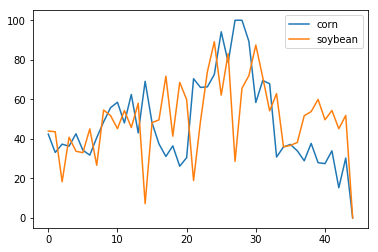

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
time_series = large_time[0]
plt.plot(time_series[0], label = 'corn')
plt.plot(time_series[1], label = 'soybean')
# plt.plot(time_series[2], label = 'forest')
# plt.plot(time_series[3], label = 'grass')
plt.legend()
# time_series
s = 


In [ ]:
def get_fractions(cdl):
    
        total_acre = sum(cdl['Acreage'])
        if total_acre == 0:
            corn = 0
            soy = 0
            forest = 0
            grass = 0
            return
        if "Corn" in cdl.index:
            corn = cdl['Acreage']['Corn'] / total_acre
        else:
            corn = 0
        if "Soybeans" in cdl.index:
            soy = cdl['Acreage']['Soybeans'] / total_acre
        else:
            soy = 0
        pattern = re.compile(r' Forest')
        trees = [cdl.index[i] for i in range(len(cdl.index))\
                 if re.search(pattern, cdl.index[i]) != None]
        frst = 0
        for tree in trees:
            frst += cdl['Acreage'][tree]
        forest = frst /  total_acre
        grass = 1 - (forest + corn + soy)
        return  np.array([corn, soy, forest, grass])

In [ ]:
print(mat)

In [ ]:
from scipy.optimize import lsq_linear

In [ ]:
result = np.linalg.lstsq(mat, rhs)

In [ ]:
print(result[0])

In [ ]:
def get_fpar_reg_series():
    
    from my_functions import get_cloud, coords_to_ind

    time_series = np.zeros((4, 45))
    qc = []
    x_values = []
    fpp = []
    
    
    prefix ='FPAR_A2016'
    suffix = '.hdf'
    ct = 0

    print(prefix+suffix)

    for i in range(1,361,8):
        a = str(int(i))
        if i < 10:
            a = '00'+ a
        elif i < 100:
            a = '0' + a

        query = prefix + a + suffix
        print(query)
        try:
            data = SD(query, SDC.READ)
#             print('get')
            FPAR_data = data.select('Fpar_500m')[:]
            QC_data = data.select('FparExtra_QC')[:]
        
            
            base_lat = 38.3
            base_lon = -89.99

            Q = QC_data[coords_to_ind(base_lon, base_lat)[1],coords_to_ind(base_lon, base_lat)[0]]
            
            if get_cloud(Q)[0] == '0' and get_cloud(Q)[1] == '0':
#                 print('inside')
                
                
                
                result = get_sifs(query)
                print(result.shape)
                fpp.append(result)
#                 print(result)
#                 time_series[:,ct] = np.array(result)
                ct += 1

        except Exception as e:
            print(e)
            continue

    return fpp

# data = SD('FPAR_A2016361.hdf', SDC.READ)

In [ ]:
#testing
time_s = get_fpar_reg_series()
print(time_s)

In [ ]:
mat = get_proportion_matrix()

In [ ]:
%matplotlib inline

time_s = np.array(time_s)
print(time_s.shape)

for i in range(16):
    if np.mean(time_s[:,i]) < 150:
        plt.plot(time_s[:,i])


        
        
1330Haiyan
# plt.figure()
# plt.plot(time_s[0], label = 'corn')
# plt.plot(time_s[1], label = 'soybeans')
# plt.plot(time_s[2], label = 'forest')
# plt.plot(time_s[3], label = 'grass')
# plt.legend()


In [ ]:
base_lon = 20
base_lat = 20
for i in range(3):
    cur_lon = base_lon
    for j in range(3):
#         rhs[row] = FPAR_data[coords_to_ind(cur_lon, base_lat)[1],coords_to_ind(cur_lon, base_lat)[0]]
        cur_lon -= 0.25
        row += 1
        print(base_lat, cur_lon)
    base_lat += 0.25
    

In [ ]:
print(1)

In [ ]:
arg_max = 'FPAR_A2016249.hdf'

print(get_sifs().x)

In [ ]:
import os
os.getcwd()

In [ ]:
print(time_s)

In [ ]:
import numpy as np

from my_functions import get_fractions, get_by_box,hasdf


base_lat, base_lon = 38.3, -89.99

mat2 = np.zeros((16,4))
row = 0
for i in range(4):
        cur_lon = base_lon
        
        for j in range(4):

            print(base_lat, cur_lon)
            mat2[row,:] = get_fractions(get_by_box(2016, cur_lon, base_lat, cur_lon - 0.1, base_lat + 0.1))
            cur_lon -= 0.1
            print(row)
            row += 1
        base_lat += 0.1

In [ ]:
import os
os.getcwd()

In [ ]:
from io import StringIO

In [ ]:
def get_by_box(year, llcrnrlon, llcrnrlat, urcrnrlon, urcrnrlat):

    x1, y1 = sifutil.convertProjection(llcrnrlon, llcrnrlat, sifutil.WGS84, sifutil.CONUS_ALBERS)
    x2, y2 = sifutil.convertProjection(urcrnrlon, urcrnrlat, sifutil.WGS84, sifutil.CONUS_ALBERS)
    url = BASE_CDL_URL + '?year=' + str(year) + '&bbox=' + str(min(x1,x2)) + "," +\
          str(min(y1, y2)) + "," + str(max(x1, x2)) + "," + str(max(y1, y2)) + "&format=csv"
    print(url)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = requests.get(url, verify = False)
        returnurl = BeautifulSoup(res.text, 'lxml').find('returnurl').text
    #print(returnurl)
    with warnings.catch_warnings():
        rawdata = requests.get(returnurl, verify = False).text
    raw_iter = StringIO(rawdata)
    df = pd.read_csv(raw_iter, sep=" *, * ")\
       .apply(pd.to_numeric, errors='ignore')\
       .set_index("Category")
    return df 


def get_fractions(cdl):
    total_acre = sum(cdl['Acreage'])
    if total_acre == 0:
        corn = 0
        soy = 0
        forest = 0
        grass = 0
        return
    if "Corn" in cdl.index:
        corn = cdl['Acreage']['Corn'] / total_acre
    else:
        corn = 0
    if "Soybeans" in cdl.index:
        soy = cdl['Acreage']['Soybeans'] / total_acre
    else:
        soy = 0
    pattern = re.compile(r' Forest')
    trees = [cdl.index[i] for i in range(len(cdl.index))\
             if re.search(pattern, cdl.index[i]) != None]
    frst = 0
    for tree in trees:
        frst += cdl['Acreage'][tree]
    forest = frst /  total_acre
    grass = 1 - (forest + corn + soy)
    return  np.array([corn, soy, forest, grass])

In [ ]:
from my_functions import hasdf

In [ ]:
print(mat2)

In [ ]:
import my_functions

In [ ]:
import numpy as np

In [ ]:
x = np.array([[2,2,2,2,2],[1,1,1,1,1]]).T
y = np.array([1,3,5,7,9])
result=  np.linalg.lstsq(x,y)


In [ ]:
result

In [ ]:
import os
os.getcwd()

In [ ]:
import p